In [1]:
import requests
import pandas as pd
import json
from datetime import datetime, timedelta
# Get today's date
end_date = datetime.now().date()
def fetch_articles_for_date(date, disease):
    params = params_base.copy()
    params['from_'] = date.strftime('%Y-%m-%d')
    params['to_'] = (date + timedelta(days=1)).strftime('%Y-%m-%d')
    params['q'] = disease
    response = requests.get(url, params=params, headers=headers)
    data = response.json()
    return data
def fetch_data_for_diseases(disease_list, end_date, num_days):
    all_data = []
    for disease in disease_list:
        data_for_disease = []
        for i in range(num_days):
            date = end_date - timedelta(days=i)
            print("Fetching data for", date.strftime('%Y-%m-%d'), disease)
            data = fetch_articles_for_date(date, disease)
            if 'articles' in data:
                articles = data['articles']
                for article in articles:
                    data_for_disease.append({
                        'title': article['title'],
                        'published_date': article['published_date'],
                        'content': article['content'],
                        'country': article['country'],
                        'disease': disease
                    })
        all_data.append({disease: data_for_disease})
    return all_data
# Example usage
url = 'https://v3-api.newscatcherapi.com/api/search?'
params_base = {
    'q': '',
    'page_size': 500,
    'lang': 'en',
    'from_': '',
    'to_': ''
}
headers = {'x-api-token': 'iq6ygxMWp3yoIT4hMoQoXgpm9cv1p47V'}
end_date = datetime.now()  # Set your desired end date
num_days = 60  # Number of days to fetch data for
disease_list = ['Measles']  # List of diseases to fetch data for
result = fetch_data_for_diseases(disease_list, end_date, num_days)
with open('fetched_data.json', 'w') as json_file:
    json.dump(result, json_file, indent=4)

Fetching data for 2024-04-17 Measles
Fetching data for 2024-04-16 Measles
Fetching data for 2024-04-15 Measles
Fetching data for 2024-04-14 Measles
Fetching data for 2024-04-13 Measles
Fetching data for 2024-04-12 Measles
Fetching data for 2024-04-11 Measles
Fetching data for 2024-04-10 Measles
Fetching data for 2024-04-09 Measles
Fetching data for 2024-04-08 Measles
Fetching data for 2024-04-07 Measles
Fetching data for 2024-04-06 Measles
Fetching data for 2024-04-05 Measles
Fetching data for 2024-04-04 Measles
Fetching data for 2024-04-03 Measles
Fetching data for 2024-04-02 Measles
Fetching data for 2024-04-01 Measles
Fetching data for 2024-03-31 Measles
Fetching data for 2024-03-30 Measles
Fetching data for 2024-03-29 Measles
Fetching data for 2024-03-28 Measles
Fetching data for 2024-03-27 Measles
Fetching data for 2024-03-26 Measles
Fetching data for 2024-03-25 Measles
Fetching data for 2024-03-24 Measles
Fetching data for 2024-03-23 Measles
Fetching data for 2024-03-22 Measles
F

In [2]:
def prep_data_for_agg_graph(file):
    disease_date_counts_dict, normalized_cases_data =prep_data_for_country_comparison(data)
    aggregated_data = {}
    for date, cases in disease_date_counts_dict['Measles'].items():
        total_cases = sum(cases.values())
        aggregated_data[date] = total_cases
    return(aggregated_data)

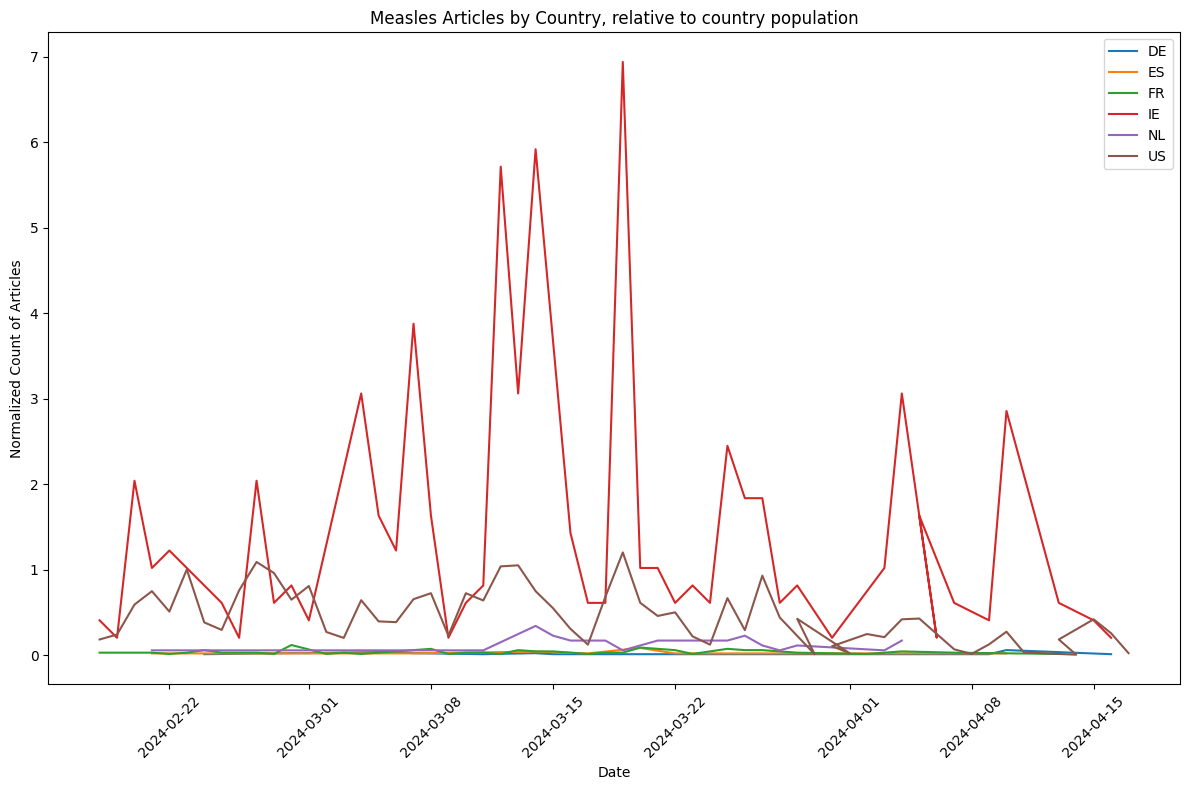

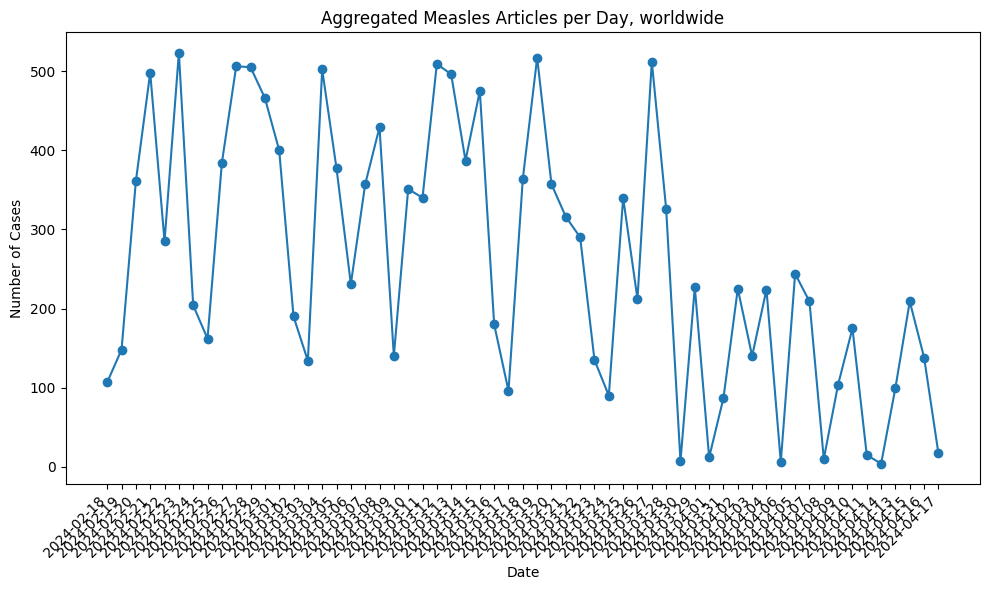

In [3]:
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
# Specify the file path of the json
#EDIT THIS
file_path = '/content/fetched_data.json'
# Open and load the JSON file
with open(file_path, 'r') as file:
    data = json.load(file)
def prep_data_for_country_comparison(file):
    # Initialize defaultdict to store disease counts by date and country
    disease_date_counts = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
    # Count unique dates for each disease
    for item in file:
        for disease_data in item.values():
            for entry in disease_data:
                disease = entry["disease"]
                published_date = entry["published_date"].split()[0]  # Extract date only
                country = entry["country"]
                disease_date_counts[disease][published_date][country] += 1
    # Convert defaultdict to regular dict with county: count format for each date
    disease_date_counts_dict = {}
    for disease, date_counts in disease_date_counts.items():
        disease_date_counts_dict[disease] = {}
        for date, country_counts in date_counts.items():
            date_dict = {}
            for country, count in country_counts.items():
                date_dict[country] = count
            disease_date_counts_dict[disease][date] = date_dict
            # Extract data for specific countries: 'UK', 'IE', 'FR'
    target_countries = ['GB', 'IE', 'FR', 'US', 'DE' , 'ES', 'NL']
    filtered_data = {}
    for disease, dates_data in disease_date_counts_dict.items():
        filtered_data[disease] = {}
        for date, countries_data in dates_data.items():
            filtered_data[disease][date] = {country: cases for country, cases in countries_data.items() if country in target_countries}
    #could use llm to get populations real-time
    country_populations = {
        "IE": 4900000,  # Ireland: 4.9 million
        "FR": 67000000,  # France: 67 million
        "DE": 83000000,  # Germany: 83 million
        "ES": 47000000,  # Spain: 47 million
        "NL": 17500000,  # Netherlands: 17.5 million
        "US": 331000000  # United States: 331 million
    }
    normalization_factor = 1000000
    # Normalize the number of cases
    normalized_cases_data = {}
    for disease, date_data in filtered_data.items():
        normalized_cases_data[disease] = {}
        for date, country_cases in date_data.items():
            normalized_cases_data[disease][date] = {}
            for country, cases in country_cases.items():
                if country in country_populations:
                    population = country_populations[country]
                    normalized_cases = (cases / population) * normalization_factor
                    normalized_cases_data[disease][date][country] = normalized_cases
    return(disease_date_counts_dict, normalized_cases_data)
def total_articles_per_day_worldwide(file):
    aggregated_data= prep_data_for_agg_graph(data)
    # Assuming you already have the aggregated_data dictionary from earlier
    # Extracting dates and counts from aggregated_data
    dates = list(aggregated_data.keys())
    counts = list(aggregated_data.values())
    # Reverse the lists
    dates_reversed = dates[::-1]
    counts_reversed = counts[::-1]
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(dates_reversed, counts_reversed, marker='o')
    plt.title('Aggregated Measles Articles per Day, worldwide')
    plt.xlabel('Date')
    plt.ylabel('Number of Cases')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
    plt.tight_layout()
    return plt
def articles_per_day_by_country(data):
    disease_date_counts_dict, normalized_cases_data = prep_data_for_country_comparison(data)
    df = pd.DataFrame(columns=['Date', 'Country', 'Value'])
    # Populate the DataFrame
    for date, country_data in normalized_cases_data['Measles'].items():
        for country, value in country_data.items():
            df.loc[len(df)] = [date, country, value]
    # Convert 'Date' column to datetime type
    df['Date'] = pd.to_datetime(df['Date'])
    # Plotting
    plt.figure(figsize=(12, 8))
    for country, group in df.groupby('Country'):
        plt.plot(group['Date'], group['Value'], label=country)
    plt.xlabel('Date')
    plt.ylabel('Normalized Count of Articles')
    plt.title('Measles Articles by Country, relative to country population')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
articles_per_day_by_country(data)
plt= total_articles_per_day_worldwide(data)